In [1]:
import numpy as np

In [2]:
X = np.array([np.random.normal(0.3, 5, 1000), np.random.normal(-3.5, 1.1, 1000)]).T

In [3]:
y = np.zeros(1000)
y[(X[:,0] < -3) | (X[:,0] > 10)] = 1

In [4]:
from sklearn.cross_validation import train_test_split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


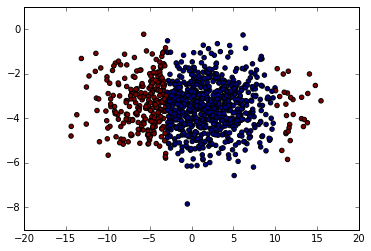

In [7]:
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

In [8]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [9]:
model = Sequential()
model.add(Dense(2, input_shape= (2,)))
model.add(Activation('relu'))
model.add(Dense(1, activation='sigmoid'))
print 'Compiling model...'
model.compile('adam', 'binary_crossentropy')
model.summary()

Compiling model...
--------------------------------------------------------------------------------
Initial input shape: (None, 2)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Dense (dense)                 (None, 2)                     6                   
Activation (activation)       (None, 2)                     0                   
Dense (dense)                 (None, 1)                     3                   
--------------------------------------------------------------------------------
Total params: 9
--------------------------------------------------------------------------------


In [12]:
MODEL_FILE = 'dummynet'

In [ ]:
try:
    model.fit(X_train, y_train, batch_size=16,
        callbacks = [
            EarlyStopping(verbose=True, patience=20, monitor='val_loss'),
            ModelCheckpoint(MODEL_FILE + '-progress', monitor='val_loss', verbose=True, save_best_only=True)
        ],
    nb_epoch=100,
    validation_split = 0.2,
    show_accuracy=True)

except KeyboardInterrupt:
    print 'Training ended early.'

# -- load in best network                                                                                                                                                                                      
model.load_weights(MODEL_FILE + '-progress')

Train on 560 samples, validate on 140 samples
Epoch 1/100
560/560 [==============================] - 0s - loss: 1.2261 - acc: 1.0000 - val_loss: 1.0882 - val_acc: 1.0000
Epoch 2/100
560/560 [==============================] - 0s - loss: 1.0454 - acc: 1.0000 - val_loss: 0.9466 - val_acc: 1.0000
Epoch 3/100
560/560 [==============================] - 0s - loss: 0.8794 - acc: 1.0000 - val_loss: 0.8077 - val_acc: 1.0000
Epoch 4/100
560/560 [==============================] - 0s - loss: 0.7267 - acc: 1.0000 - val_loss: 0.6916 - val_acc: 1.0000
Epoch 5/100
560/560 [==============================] - 0s - loss: 0.6010 - acc: 1.0000 - val_loss: 0.5955 - val_acc: 1.0000
Epoch 6/100
560/560 [==============================] - 0s - loss: 0.5043 - acc: 1.0000 - val_loss: 0.5187 - val_acc: 1.0000
Epoch 7/100
560/560 [==============================] - 0s - loss: 0.4329 - acc: 1.0000 - val_loss: 0.4659 - val_acc: 1.0000
Epoch 8/100
560/560 [==============================] - 0s - loss: 0.3848 - acc: 1.0000

In [15]:
# -- save model and weights to protobufs
import tensorflow as tf                                                                                                                                                                                        
import keras.backend.tensorflow_backend as tfbe                                                                                                                                                                

sess = tfbe._SESSION                                                                                                                                                                                           
saver = tf.train.Saver()                                                                                                                                                                                       
tf.train.write_graph(sess.graph_def, 'models/', 'graph.pb', as_text=False)                                                                                                                                     
save_path = saver.save(sess, "./model-weights.ckpt")                                                                                                                                                           
print "Model saved in file: %s" % save_path                                                                                                                                                                    

# -- print out this information: it will be useful when freezing the graph
print 'filename_tensor_name = ' + saver.as_saver_def().filename_tensor_name                                                                                                                                                                
print 'restore_op_name = ' + saver.as_saver_def().restore_op_name                                                                                                                                                                     


Model saved in file: ./model-weights.ckpt
filename_tensor_name = save_1/Const:0
restore_op_name = save_1/restore_all


In [16]:
# -- find out the name of your output node: it will be useful when freezing the graph and evaluating
model.get_output()

<tf.Tensor 'Sigmoid_2:0' shape=(?, 1) dtype=float32>

In [17]:
# -- find out the name of your output node: it will be useful when evaluating
model.get_input()

<tf.Tensor 'Placeholder:0' shape=(?, 2) dtype=float32>

In [18]:
# -- testing
yhat = model.predict(X_test, verbose = True, batch_size = 516)

300/300 [==============================] - 0s


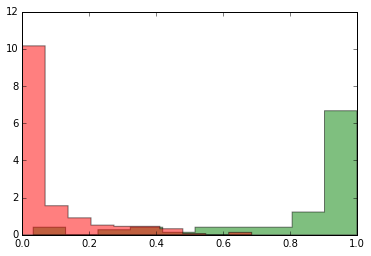

In [19]:
# -- plot classifier output
_ = plt.hist(yhat[y_test == 1], normed = True, histtype = 'stepfilled', color = 'green', alpha = 0.5)
_ = plt.hist(yhat[y_test == 0], normed = True, histtype = 'stepfilled', color = 'red', alpha = 0.5)

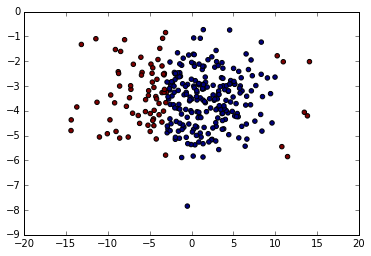

In [20]:
# -- real flavor of test set examples
plt.scatter(X_test[:,0], X_test[:,1], c=y_test)
plt.show()

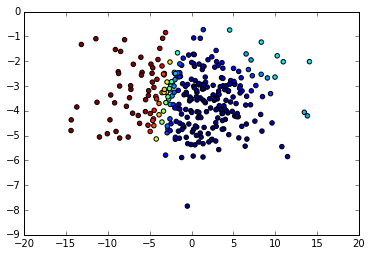

In [21]:
# -- net predictions on test set examples
plt.scatter(X_test[:,0], X_test[:,1], c=yhat)
plt.show()

# Pick an example to test if load.cc works

In [25]:
# -- inputs
X_test[0]

array([ 3.24311246, -5.56385935])

In [26]:
# -- predicted output (using Keras)
yhat[0]

array([ 0.00248217])

# Inspect the protobuf containing the model's architecture and logic

In [27]:
from tensorflow.core.framework import graph_pb2

# -- read in the graph
f = open("models/graph.pb", "rb")
graph_def = graph_pb2.GraphDef()
graph_def.ParseFromString(f.read())

In [28]:
import tensorflow as tf
# -- actually import the graph described by graph_def
tf.import_graph_def(graph_def, name = '')

In [29]:
for node in graph_def.node:
    print node.name

Placeholder
dense_W/initial_value
dense_W
dense_W/Assign
dense_W/read
dense_b/initial_value
dense_b
dense_b/Assign
dense_b/read
dense_W_1/initial_value
dense_W_1
dense_W_1/Assign
dense_W_1/read
dense_b_1/initial_value
dense_b_1
dense_b_1/Assign
dense_b_1/read
Variable/initial_value
Variable
Variable/Assign
Variable/read
Variable_1/initial_value
Variable_1
Variable_1/Assign
Variable_1/read
Variable_2/initial_value
Variable_2
Variable_2/Assign
Variable_2/read
Variable_3/initial_value
Variable_3
Variable_3/Assign
Variable_3/read
MatMul
add
Neg
Relu
Relu_1
Const
mul
sub
MatMul_1
add_1
Sigmoid
MatMul_2
add_2
Neg_1
Relu_2
Relu_3
Const_1
mul_1
sub_1
MatMul_3
add_3
Sigmoid_1
Placeholder_1
Placeholder_2
Cast/x
Cast_1/x
clip_by_value/Minimum
clip_by_value
sub_2/x
sub_2
div
Log
logistic_loss/Relu
logistic_loss/mul
logistic_loss/sub
logistic_loss/Abs
logistic_loss/Neg
logistic_loss/Exp
logistic_loss/add/x
logistic_loss/add
logistic_loss/Log
logistic_loss
Mean/reduction_indices
Mean
Mean_1/reductio